In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import sys
import os
sys.path.append(os.path.abspath('../..'))
from project_paths import PROJECT_ROOT
from functions import get_params_string
from Paper.figure_scripts import common

In [4]:
L = 16
n_dim = 1
PBC = True
model_label = "TFIM"
hs = np.arange(0.5, 10, 0.5)
model_params = lambda x: {"J": 1, "h": x}
N_therm = 2 ** np.arange(10, 20)

folder = f"{PROJECT_ROOT}Data/LPSE/Noisy_rbm/Acceptance/"
sigmas = np.concatenate(([0], np.logspace(-3, 3, 100))) 

In [5]:
acceptance = np.zeros((len(hs), len(sigmas)))

for m, h in enumerate(hs):
    params_str = get_params_string(model_params(h))
    df = pd.read_csv(f"{folder}{model_label}{params_str}_L{L}_{n_dim}dim.csv")
    mask = df["Sigma"].apply(lambda x: np.any(np.isclose(x, sigmas, rtol=1e-2)))
    df = df[mask].sort_values(by="Sigma")
    acceptance[m, :] = df["Acceptance"].to_numpy()

folder = f"{PROJECT_ROOT}Data/LPSE/Ratio/"
ratio_mean = []
ratio_error = []
ratio_median = []

for h in hs:
    param_str = get_params_string({"J": 1, "h": h})
    df = pd.read_csv(f"{folder}{model_label}{param_str}_RBM_alpha1_L{L}_{n_dim}dim.csv")
    r = df["Ratio"].to_numpy()
    ratio_mean.append(np.mean(r))
    ratio_error.append(np.std(r))
    ratio_median.append(np.median(r))

ratio_mean = np.array(ratio_mean).reshape((len(hs), -1))
ratio_error = np.array(ratio_error).reshape((len(hs), -1))
ratio_median = np.array(ratio_median).reshape((len(hs), -1))

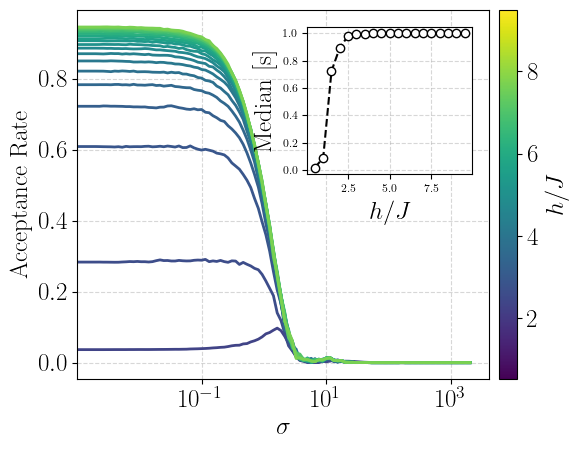

In [6]:
fig, ax = plt.subplots()

colors = cm.viridis(np.linspace(0.2, 0.8, len(hs)))
norm = mcolors.Normalize(vmin=min(hs), vmax=max(hs))
sm = cm.ScalarMappable(norm=norm, cmap=cm.viridis)

for i, h in enumerate(hs):
    ax.plot(sigmas * 2, acceptance[i], color=colors[i], lw=2)

ax.set_xscale("log")
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel("Acceptance Rate")
ax.grid(ls="--", alpha=0.5)

cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label(r"$h/J$")

ax_inset = inset_axes(
    ax,
    width="40%", height="40%",
    loc="upper right",
    borderpad=1
)
ax_inset.plot(
    hs, ratio_median,
    marker="o", ls="--",
    color="black", markerfacecolor="white"
)
ax_inset.set_xlabel(r"$h/J$")
ax_inset.set_ylabel("Median [s]")
ax_inset.tick_params(labelsize=8)
ax_inset.grid(ls="--", alpha=0.5)